In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime
import itertools
from time import sleep
import os
import seaborn as sns
from itertools import chain


In [2]:
# get the DF used for setting the weights and analysis
print datetime.datetime.now()
validFilePaths = []
for f in os.listdir("data/anomaly_data"):
    filePath = os.path.join("data/anomaly_data", f)
    if os.path.isdir(filePath):
        continue
    if os.stat(filePath).st_size <= 3:
        continue
    validFilePaths.append(filePath)
    
numF = int(0.5 * len(validFilePaths))
print 'Using this many files {0}'.format(numF)
validFilePaths = np.random.choice(validFilePaths, numF, replace=False)
df_list = (pd.read_csv(f) for f in validFilePaths)
df = pd.concat(df_list, ignore_index=True)
df1 = df[df['radiant_win'].notnull()]

2017-05-28 05:09:06.488943
Using this many files 4978


In [3]:

df2 = pd.DataFrame(np.loadtxt('data/goodAnomaliesResidual.csv', delimiter = ','), 
                 columns = ["match_id", "residual"])

df = df1.merge(df2, left_on='match_id', right_on='match_id')

matchDictionary = {}
heroColumns = [filter(lambda x: z in x, df.columns) for z in ['hero_id']][0]

# for each row, this function will return all the heroes that the match belongs in
# for example, if the match had an AM and Spectre, we should place this match in each of those bags
def heroesForMatch(row):
    pass

In [4]:
df = df[~df['match_id'].duplicated()]

In [5]:
df = df.sort_values(by='residual', ascending=False)

In [6]:
columns = df.columns
numericalFeatures = ['match_id', 'positive_votes', 'negative_votes', 'first_blood_time', 'radiant_win',
                    'duration', 'kills', 'deaths', 'assists', 'apm', 'kpm', 'kda', 'hero_dmg',
                    'gpm', 'hero_heal', 'xpm', 'totalgold', 'totalxp', 'lasthits', 'denies',
                    'tower_kills', 'courier_kills', 'gold_spent', 'observer_uses', 'sentry_uses',
                    'ancient_kills', 'neutral_kills', 'camps_stacked', 'pings', 'rune_pickups', 'residual']
numFeatures = [filter(lambda x: z in x, columns) for z in numericalFeatures]
numFeatures = list(chain(*numFeatures))
df = df[numFeatures]

In [7]:
df['match_id'].values.tolist()

[3123906560,
 3123365632,
 3123471104,
 3123843584,
 3123658752,
 3123094016,
 3123779328,
 3123481088,
 3123663360,
 3123467776,
 3123057408,
 3123486720,
 3123088384,
 3122996992,
 3123678976,
 3123429376,
 3123045888,
 3123770624,
 3123082240,
 3123564288,
 3123057664,
 3123667200,
 3123871232,
 3123352576,
 3123351808,
 3123910912,
 3123553024,
 3123015936,
 3123666688,
 3123352064,
 3123194368,
 3123582976,
 3123577344,
 3123347456,
 3123874304,
 3123882752,
 3123269376,
 3123665152,
 3123847936,
 3123365120,
 3123257088,
 3123458048,
 3123060992,
 3123402752,
 3123790592,
 3123929856,
 3123369728,
 3123438336,
 3123286784,
 3123744256,
 3123898368,
 3123214592,
 3123877120,
 3123717632,
 3123591168,
 3123472640,
 3123113984,
 3123678464,
 3123415552,
 3123339264,
 3123247616,
 3123153920,
 3123553792,
 3123431680,
 3123026176,
 3123339776,
 3123112704,
 3123800320,
 3123592192,
 3123331072,
 3123452160,
 3123937536,
 3123510528,
 3123604736,
 3123813888,
 3123177728,
 3123063296,

In [8]:
df['residual'].values.tolist()

[17.769739151000977,
 16.43926429748535,
 15.667449951171875,
 15.470060348510742,
 15.118217468261719,
 14.945989608764648,
 14.812270164489746,
 14.720905303955078,
 14.547149658203125,
 14.521434783935547,
 14.210748672485352,
 14.036528587341309,
 13.981718063354492,
 13.821186065673828,
 13.472919464111328,
 13.453269004821777,
 13.433164596557617,
 13.182275772094727,
 13.1610689163208,
 13.118196487426758,
 13.103710174560547,
 13.014297485351562,
 12.750572204589844,
 12.579961776733398,
 12.538928031921387,
 12.50808048248291,
 12.298011779785156,
 11.840034484863281,
 11.595903396606445,
 11.342506408691406,
 11.198140144348145,
 11.162935256958008,
 11.03091049194336,
 10.897855758666992,
 10.332125663757324,
 10.26290512084961,
 9.998414993286133,
 9.569059371948242,
 9.565494537353516,
 9.46358871459961,
 9.356596946716309,
 9.348721504211426,
 9.321592330932617,
 9.249642372131348,
 9.136567115783691,
 9.113801002502441,
 9.069816589355469,
 9.030654907226562,
 9.02446746

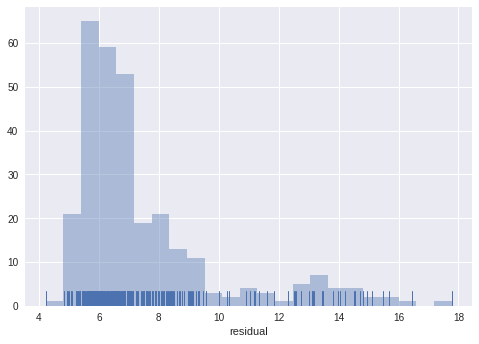

In [9]:
sns.distplot(df['residual'],  kde=False, rug=True)
plt.show()

In [10]:
len(df)

302

In [11]:
plt.close()

In [12]:
residuals = df['residual'].values.tolist()

In [13]:
np.max(residuals) - np.min(residuals)

13.54086971282959

In [14]:
df['residual']

137    17.769739
179    16.439264
64     15.667450
191    15.470060
224    15.118217
95     14.945990
49     14.812270
270    14.720905
288    14.547150
261    14.521435
65     14.210749
183    14.036529
37     13.981718
74     13.821186
219    13.472919
164    13.453269
97     13.433165
91     13.182276
229    13.161069
76     13.118196
35     13.103710
116    13.014297
61     12.750572
38     12.579962
240    12.538928
16     12.508080
239    12.298012
283    11.840034
190    11.595903
251    11.342506
         ...    
27      5.492200
241     5.490740
263     5.485778
6       5.485070
84      5.482734
249     5.470408
142     5.437362
273     5.429682
254     5.377345
50      5.364038
75      5.362405
185     5.343768
212     5.303561
66      5.302567
42      5.300011
12      5.294446
202     5.292239
199     5.258973
279     5.254524
20      5.244771
221     5.236786
101     5.092525
17      5.087733
113     5.069938
286     5.018312
33      4.965495
153     4.933017
203     4.9260

In [15]:
def RadiantDireDifference(row, column):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    radiantSum = 0
    direSum = 0
    for pos in poss:
        radiantSum += row['radiant_'+ pos + '_' + column]
        direSum += row['dire_'+ pos + '_' + column]
    return radiantSum - direSum

def reject_outliers(data, m=1.5):
    return abs(data - np.mean(data)) < m * np.std(data)

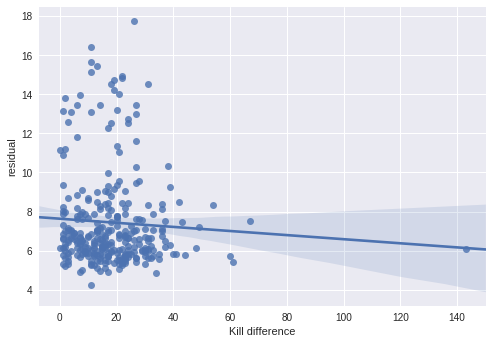

In [16]:
kill_difference = np.abs(df.apply(RadiantDireDifference, args=('kills',), axis=1))
sns.regplot(kill_difference, df['residual'])
ax = plt.gca()
ax.set_xlabel("Kill difference")
plt.show()

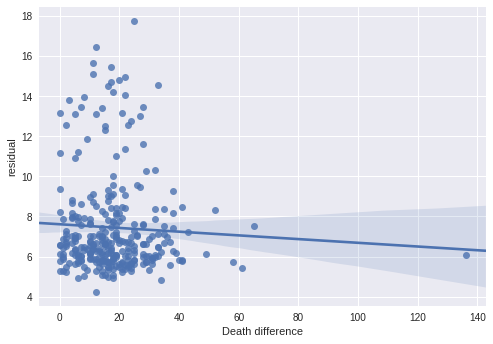

In [17]:
death_difference = df.apply(RadiantDireDifference, args=('deaths',), axis=1)
sns.regplot(np.abs(death_difference), df['residual'])
ax = plt.gca()
ax.set_xlabel("Death difference")
plt.show()

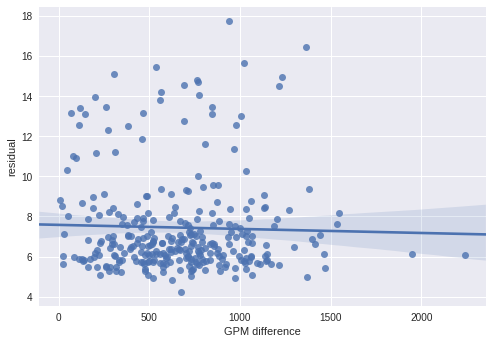

In [18]:
gold_difference = df.apply(RadiantDireDifference, args=('gpm',), axis=1)
sns.regplot(np.abs(gold_difference), df['residual'])
ax = plt.gca()
ax.set_xlabel("GPM difference")
plt.show()

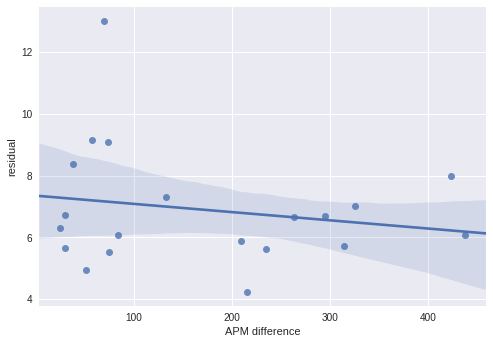

In [19]:
apm_difference = df.apply(RadiantDireDifference, args=('apm',), axis=1)
sns.regplot(np.abs(apm_difference), df['residual'])
ax = plt.gca()
ax.set_xlabel("APM difference")
plt.show()

In [20]:
df[df['residual'] > 17]

,match_id,positive_votes,negative_votes,first_blood_time,radiant_win,duration,dire_pos1_ancient_kills,dire_pos1_courier_kills,dire_pos1_kills,dire_pos1_neutral_kills,...,dire_pos2_rune_pickups,dire_pos3_rune_pickups,dire_pos4_rune_pickups,dire_pos5_rune_pickups,radiant_pos1_rune_pickups,radiant_pos2_rune_pickups,radiant_pos3_rune_pickups,radiant_pos4_rune_pickups,radiant_pos5_rune_pickups,residual
137,3123906560,0,0,85,True,2385,NaN,NaN,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.769739


In [21]:
df[df['residual'] < 7.5].sample(10, random_state=1)

,match_id,positive_votes,negative_votes,first_blood_time,radiant_win,duration,dire_pos1_ancient_kills,dire_pos1_courier_kills,dire_pos1_kills,dire_pos1_neutral_kills,...,dire_pos2_rune_pickups,dire_pos3_rune_pickups,dire_pos4_rune_pickups,dire_pos5_rune_pickups,radiant_pos1_rune_pickups,radiant_pos2_rune_pickups,radiant_pos3_rune_pickups,radiant_pos4_rune_pickups,radiant_pos5_rune_pickups,residual
254,3123034624,0,0,150,False,3233,NaN,NaN,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.377345
90,3123668480,0,0,40,False,1915,NaN,NaN,7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.722015
85,3123261184,0,0,186,True,2940,NaN,NaN,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.647280
17,3123883776,0,0,7,False,2466,NaN,NaN,11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.087733
166,3123273472,0,0,243,False,3231,NaN,NaN,12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.623017
3,3123372544,0,0,89,False,2395,NaN,NaN,12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.854605
232,3123898624,0,0,167,True,3754,NaN,NaN,8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.756660
269,3123077376,0,0,226,True,2404,NaN,NaN,9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.046832
286,3123496704,0,0,66,False,2021,NaN,NaN,11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.018312
55,3123183104,0,0,12,True,743,NaN,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.581025
